# Introduction

This is a bare-bones "project" designed to incorporate digital elevation of a map, image processing, and graph search, to answer the question "what is the optimal path to get from point A to point B through rugged terrain". I've included links to tutorials that go into much greater depth for each technique. 

In [ ]:
# Tutorial: http://www.qgistutorials.com/en/docs/working_with_terrain.html
# Data: http://earthexplorer.usgs.gov/

In [81]:
%matplotlib inline
import gdal
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

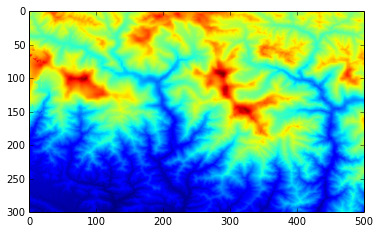

In [82]:
# Load the digital elevation map for the area near Everest, read as a numpy array
d = gdal.Open('10n060e_20101117_gmted_mea075.tif')
elevation_arr = d.ReadAsArray()
elevation_arr = elevation_arr[600:900,11500:12000] # choose an interesting subsection
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(elevation_arr)

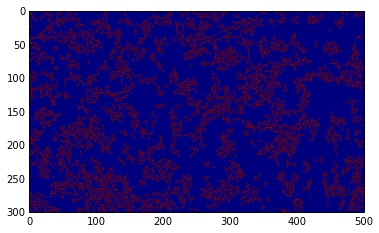

In [83]:
# see what we can do with edges using Canny edge detection
# see: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html#canny
import cv2
import copy
edges = cv2.Canny( np.uint8( copy.copy(elevation_arr) ), 100, 1000) # thresholds are for minval and maxval
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(edges)
# doesn't look super helpful, as it misses the big but smooth features

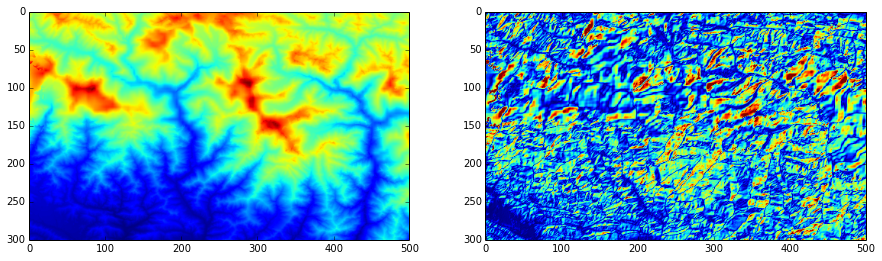

In [84]:
# see what the gradient (slope angle) looks like
fig = plt.figure(figsize=(15,5))

# plot the map with the path overlaid in black
ax = fig.add_subplot(121)
ax.imshow(elevation_arr)

# plot the slope magnitude with the path overlaid in black
gradient = np.gradient(elevation_arr)
gradient = np.abs(np.sum(gradient, axis=0))
ax = fig.add_subplot(122)
ax.imshow(gradient, vmax=300)
# the main features are difficult to extract, again, not very promising

In [85]:
# now try using graph search theory - A* search - with changes in elevation as the cost
# Great tutorial: http://www.redblobgames.com/pathfinding/a-star/introduction.html
# Networkx info: https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.shortest_paths.html

# create graph from map, each pixel gets a node, connected to neighboring nodes
# edge cost = difference in elevation
# this is not very efficient - very slow - but let's try
import networkx as nx
G = nx.Graph()
n = 1
node_ids = np.zeros_like(elevation_arr).astype(np.int64) # this array links the node numbers to their map positions
gradient = np.gradient(elevation_arr)
gradient = np.abs(np.sum(gradient, axis=0))
for px in range(0,elevation_arr.shape[0]-2):
    for py in range(0,elevation_arr.shape[1]-2):
        G.add_node(n,{'px':px,'py':py})
        slope_cost = gradient[px,py]
        xedges = [-1,0,1]
        yedges = [-1,0,1]
        for xedge in xedges:
            for yedge in yedges:
                if node_ids[px+xedge,py+yedge] != 0:
                    moderate = (np.abs(elevation_arr[px,py] - elevation_arr[px+xedge,py+yedge]))**1.5 + 1 
                    easy = (np.abs(elevation_arr[px,py] - elevation_arr[px+xedge,py+yedge]))**4 + 1 
                    strenuous = (np.abs(elevation_arr[px,py] - elevation_arr[px+xedge,py+yedge]))**0.5 + 1 
                    # the 1.5 is a scaling factor - the bigger this is, the more changes in elevation cost
                    minimize_traverse = moderate + slope_cost
                    G.add_edge(n,node_ids[px+xedge,py+yedge],{'easy':easy, 'moderate':moderate, 
                                                              'strenuous':strenuous, 'minimize_traverse':minimize_traverse})
                    #G.add_edge(node_ids[px+xedge,py+yedge],n,{'cost':cost,'weight':1.})
        node_ids[px,py] = n
        if n < 0:
            print n
        n += 1      

In [86]:
# A* search needs a heuristic that returns an approximate distance from node a to node b
# euclidian distance works for us here
def make_heuristic(G):
    def heuristic(a, b):
        return (G.node[a]['px']-G.node[b]['px'])**2 + (G.node[a]['py']-G.node[b]['py'])**2
    return heuristic

In [87]:
def run_a_star_and_plot(G,starting_node,ending_node,cost):
    path = nx.astar_path(G,starting_node,ending_node,make_heuristic(G),cost)
    path_img = np.ones_like(elevation_arr)*np.nan
    for node in path:
        px, py = np.where(node_ids==node)
        path_img[px,py]=0

    my_cmap = copy.copy(plt.cm.get_cmap('gray')) # get a copy of the gray color map
    my_cmap.set_bad(alpha=0) # set how the colormap handles 'bad' values

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(121)

    # plot the map with the path overlaid in black
    ax.imshow(elevation_arr)
    ax.imshow(path_img, cmap=my_cmap)

    # plot the slope magnitude with the path overlaid in black
    gradient = np.gradient(elevation_arr)
    gradient = np.abs(np.sum(gradient, axis=0))
    ax = fig.add_subplot(122)
    ax.imshow(gradient, vmax=300)
    ax.imshow(path_img, cmap=my_cmap)

In [88]:
starting_node = 24951
ending_node = 75151

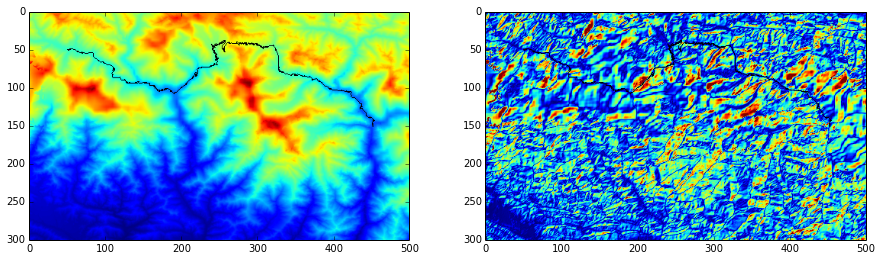

In [89]:
# easy - minimize elevation changes
run_a_star_and_plot(G,starting_node,ending_node,'easy')
# left plot shows terrain with path in black
# right plot shows slope angle, with path in black

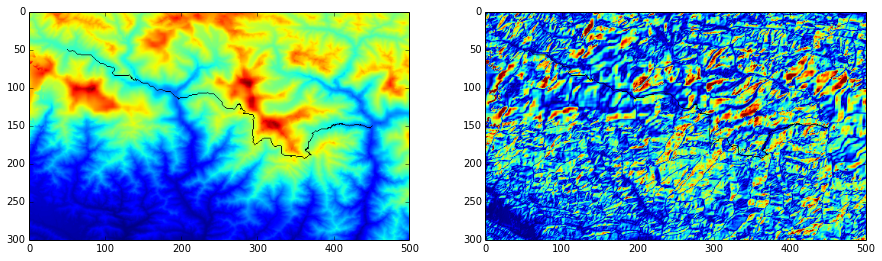

In [90]:
# moderate
run_a_star_and_plot(G,starting_node,ending_node,'moderate')

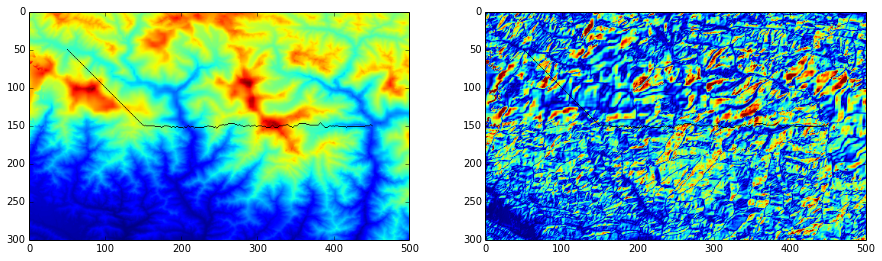

In [91]:
# strenuous - don't care much about elevation changes
run_a_star_and_plot(G,starting_node,ending_node,'strenuous')

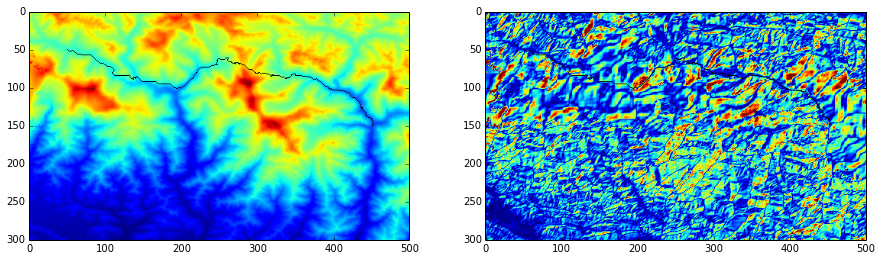

In [92]:
# minimize traverses
run_a_star_and_plot(G,starting_node,ending_node,'minimize_traverse')

=== Executing: ===
# now try using graph search theory - A* search - with changes in elevation as the cost
# Great tutorial: http://www.redblobgames.com/pathfinding/a-star/introduction.html
# Networkx info: https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.shortest_paths.html

# create graph from map, each pixel gets a node, connected to neighboring nodes
# edge cost = difference in elevation
# this is not very efficient - very slow - but let's try
import networkx as nx
G = nx.Graph()
n = 1
node_ids = np.zeros_like(elevation_arr).astype(np.int64) # this array links the node numbers to their map positions
gradient = np.gradient(elevation_arr)
gradient = np.abs(np.sum(gradient, axis=0))
for px in range(0,elevation_arr.shape[0]-2):
    for py in range(0,elevation_arr.shape[1]-2):
        G.add_node(n,{'px':px,'py':py})
        slope_cost = gradient[px,py]
        xedges = [-1,0,1]
        yedges = [-1,0,1]
        for xedge in xedges:
            for yedge in yed

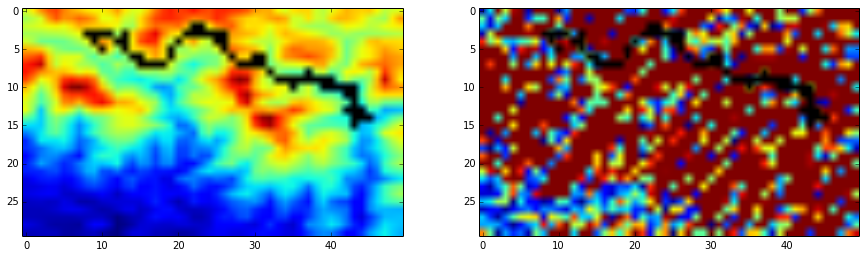

In [80]:
# Now try to resize the array, and see how it turns out
elevation_arr = cv2.resize( elevation_arr, (50,30) )
%rerun 68 # calculate a new graph
starting_node = 251
ending_node = 718
run_a_star_and_plot(G,starting_node,ending_node,'moderate')

# Conclusion

The algorithm works nicely, however, it is very computationally intensive. To reduce the computation time the number of nodes needs to be reduced. Here are two ideas:

1. Calculate the route using a reduced size image (as demonstrated above), then recalculate the graph for some space around the determined route. This will have failure modes, but may work reasonably well?
2. Lump all neighboring pixels that are of similar elevation into a single node (for example, using the gradient map, or pre-computed contours). The tricky part will be linking the graph search results back to the map, e.g. drawing the path through the map across a space that was defined to be a single node. For example, a valley could be considered one node, but in order to draw the path on the map, that node must be expanded.  